# Spanish Translation A/B Test

Company XYZ is a worldwide e-commerce site with localized versions of the site.

A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than any other Spanish-speaking country. She therefore went and talked to the international team in charge of Spain And LatAm to see if they had any ideas about why that was happening.

Spain and LatAm country manager suggested that one reason could be translation. All Spanish- speaking countries had the same translation of the site which was written by a Spaniard. They agreed to try a test where each country would have its one translation written by a local. That is, Argentinian users would see a translation written by an Argentinian, Mexican users by a Mexican and so on. Obviously, nothing would change for users from Spain.
After they run the test however, they are really surprised cause the test is negative. I.e., it appears that the non-localized translation was doing better!

You are asked to:

1.Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better

2.Explain why that might be happening. Are the localized translations really worse?

3.If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.

# Data
We have 2 tables that can be found on this repo.
The 2 tables are:
## "test_table" - general information about the test results
### Columns:
**user_id** : the id of the user. Unique by user. Can be joined to user id in the other table.
For each user, we just check whether conversion happens the first time they land on the
site since the test started.  
**date** : when they came to the site for the first time since the test started         
**source** : marketing channel: Ads, SEO, Direct . Direct means everything except for ads
and SEO. Such as directly typing site URL on the browser, downloading the app w/o
coming from SEO or Ads, referral friend, etc.      
**device** : device used by the user. It can be mobile or web     
**browser_language** : in browser or app settings, the language chosen by the user. It can
be EN, ES, Other (Other means any language except for English and Spanish)      
**ads_channel** : if marketing channel is ads, this is the site where the ad was displayed. It
can be: Google, Facebook, Bing, Yahoo ,Other. If the user didn't come via an ad, this
field is NA     
**browser** : user browser. It can be: IE, Chrome, Android_App, FireFox, Iphone_App,
Safari, Opera     
**conversion** : whether the user converted (1) or not (0). This is our label. A test is
considered successful if it increases the proportion of users who convert.    
**test** : users are randomly split into test (1) and control (0). Test users see the new
translation and control the old one. For Spain-based users, this is obviously always 0
since there is no change there.    
## "user_table" - some information about the user
### Columns:
**user_id** : the id of the user. It can be joined to user id in the other table   
**sex** : user sex: Male or Female    
**age** : user age (self-reported)   
**country** : user country based on ip address

In [1]:
%matplotlib inline
import random
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder
# from numpy.linalg import inv
import pdpbox
from pdpbox import pdp
from pdpbox.info_plots import target_plot

from statsmodels.multivariate.manova import MANOVA

In [2]:
test_table = pd.read_csv('test_table.csv')
user_table = pd.read_csv('user_table.csv')
test_table.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [3]:
user_table.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [4]:
data = pd.merge(test_table, user_table, how='inner', on='user_id', left_on=None, right_on=None,
      left_index=False, right_index=False, sort=True,
      suffixes=('_x', '_y'), copy=True, indicator=False)
data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,1,2015-12-02,SEO,Web,EN,NaN,Chrome,0,0,M,38,Chile
1,2,2015-11-30,SEO,Mobile,ES,NaN,Android_App,0,0,M,27,Colombia
2,3,2015-12-03,SEO,Mobile,ES,NaN,Iphone_App,0,1,M,18,Guatemala
3,5,2015-11-30,Ads,Web,ES,Facebook,Chrome,0,1,M,22,Argentina
4,8,2015-12-03,Ads,Mobile,ES,Google,Android_App,0,1,M,19,Venezuela


In [5]:
data.describe()

,user_id,conversion,test,age
count,452867.000000,452867.000000,452867.000000,452867.000000
mean,499944.805166,0.049560,0.476462,27.130740
std,288676.264784,0.217034,0.499446,6.776678
min,1.000000,0.000000,0.000000,18.000000
25%,249819.000000,0.000000,0.000000,22.000000
50%,500019.000000,0.000000,0.000000,26.000000
75%,749543.000000,0.000000,1.000000,31.000000
max,1000000.000000,1.000000,1.000000,70.000000


In [6]:
data[['country', 'browser', 'ads_channel', 'device', 'source', 'date']].describe()

,country,browser,ads_channel,device,source,date
count,452867,452867,181693,452867,452867,452867
unique,17,7,5,2,3,5
top,Mexico,Android_App,Facebook,Web,Ads,2015-12-04
freq,128484,154977,68358,251316,181693,141024


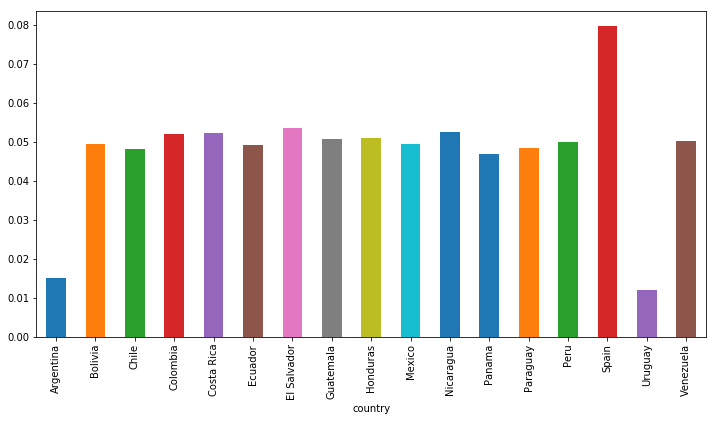

In [7]:
plt.figure(figsize=(12, 6))
data[data['test']==0].groupby('country')['conversion'].mean().plot(kind='bar')

In [8]:
print('Test proportion:')
print(sum(data['test'])/data.shape[0])
print('Control proportion:')
print(1-sum(data['test'])/data.shape[0])

Test proportion:
0.4764621842616044
Control proportion:
0.5235378157383956


In [9]:
print(st.ttest_ind(data[(data['test']==0) & (data['country']!='Spain')]['conversion'], data[data['test']==1]['conversion'], equal_var = False))

Ttest_indResult(statistic=7.353895203080277, pvalue=1.9289178577799033e-13)


In [10]:
print('Conversion for control set:')
print(data[(data['test']==0) & (data['country']!='Spain')]['conversion'].mean())
print('Conversion for test set:')
print(data[data['test']==1]['conversion'].mean())

Conversion for control set:
0.04829179055749524
Conversion for test set:
0.043411161678422794


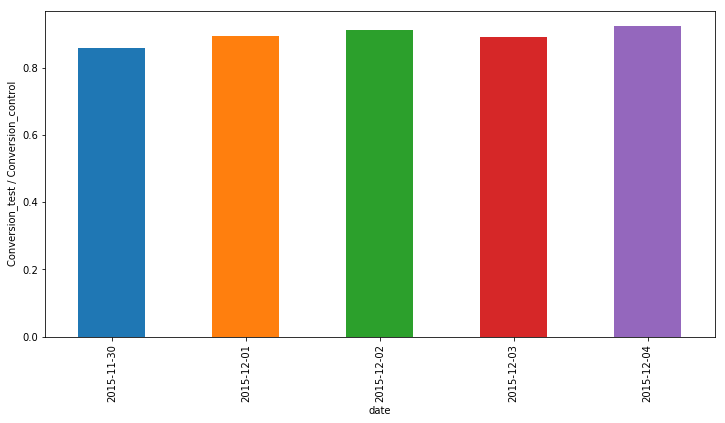

In [11]:
plt.figure(figsize=(12, 6))
plt.ylabel('Conversion_test / Conversion_control')
(data[(data['test']==1) & (data['country']!='Spain')].groupby('date')['conversion'].mean()
         /data[(data['test']==0) & (data['country']!='Spain')].groupby('date')['conversion'].mean()).plot(kind='bar')

### Invariant check

There should be no significant difference between test and control group in the distributions of date, source, device, ads_channel, browser, sex, age, country.
So, I am going to use t-test and  to check.

In [12]:
data.columns

Index(['user_id', 'date', 'source', 'device', 'browser_language',
       'ads_channel', 'browser', 'conversion', 'test', 'sex', 'age',
       'country'],
      dtype='object')

In [13]:
data0 = data.fillna('UNKONWN')
data1 = data0[data0['browser_language']=="ES"]
vars = list(data0.columns)
vars.remove('user_id')
vars.remove('browser_language')
vars.remove('conversion')
vars.remove('test')
data1_0=data0[['user_id','browser_language','conversion','test']]

In [14]:
data1 = pd.DataFrame(data)
data1.fillna('UNKNOWN')

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,1,2015-12-02,SEO,Web,EN,UNKNOWN,Chrome,0,0,M,38,Chile
1,2,2015-11-30,SEO,Mobile,ES,UNKNOWN,Android_App,0,0,M,27,Colombia
2,3,2015-12-03,SEO,Mobile,ES,UNKNOWN,Iphone_App,0,1,M,18,Guatemala
3,5,2015-11-30,Ads,Web,ES,Facebook,Chrome,0,1,M,22,Argentina
4,8,2015-12-03,Ads,Mobile,ES,Google,Android_App,0,1,M,19,Venezuela
5,11,2015-12-03,Ads,Web,ES,Yahoo,Chrome,0,1,F,28,Colombia
6,12,2015-12-04,Direct,Web,ES,UNKNOWN,IE,0,0,F,32,Colombia
7,13,2015-12-04,Direct,Web,ES,UNKNOWN,IE,0,1,M,21,Paraguay
8,15,2015-12-02,Ads,Web,ES,Yahoo,Safari,0,1,F,30,Mexico
9,19,2015-12-04,SEO,Mobile,ES,UNKNOWN,Android_App,0,0,M,32,Peru


In [15]:
for v in ['date', 'source', 'device', 'browser_language',
       'ads_channel', 'browser', 'sex', 'age','country']:
    print(pd.DataFrame(data1.groupby(v)['test'].sum())/pd.DataFrame(data1.groupby(v)['test'].count()))

                test
date                
2015-11-30  0.477025
2015-12-01  0.477191
2015-12-02  0.474873
2015-12-03  0.476695
2015-12-04  0.476444
            test
source          
Ads     0.475792
Direct  0.474410
SEO     0.478170
            test
device          
Mobile  0.477576
Web     0.475569
                      test
browser_language          
EN                0.477275
ES                0.476185
Other             0.480678
                 test
ads_channel          
Bing         0.476079
Facebook     0.477003
Google       0.475357
Other        0.465846
Yahoo        0.475209
                 test
browser              
Android_App  0.478181
Chrome       0.478826
FireFox      0.475406
IE           0.473887
Iphone_App   0.475566
Opera        0.473866
Safari       0.470426
         test
sex          
F    0.477270
M    0.475887
         test
age          
18   0.479098
19   0.475444
20   0.474044
21   0.476432
22   0.476857
23   0.477646
24   0.477560
25   0.480970
26   0.481281
27 

In [16]:
for v in vars: 
    df2 = data1[[v]]
    df2 = (pd.get_dummies(df2, prefix='', prefix_sep='')
                   .max(level=0, axis=1)
                   .add_prefix(v+'_'))
    data1 = pd.concat([data1, df2], axis=1)
    data1 = data1.drop([v], axis=1) 

In [17]:
data1.columns

Index(['user_id', 'browser_language', 'conversion', 'test', 'date_2015-11-30',
       'date_2015-12-01', 'date_2015-12-02', 'date_2015-12-03',
       'date_2015-12-04', 'source_Ads', 'source_Direct', 'source_SEO',
       'device_Mobile', 'device_Web', 'ads_channel_Bing',
       'ads_channel_Facebook', 'ads_channel_Google', 'ads_channel_Other',
       'ads_channel_Yahoo', 'browser_Android_App', 'browser_Chrome',
       'browser_FireFox', 'browser_IE', 'browser_Iphone_App', 'browser_Opera',
       'browser_Safari', 'sex_F', 'sex_M', 'age_age', 'country_Argentina',
       'country_Bolivia', 'country_Chile', 'country_Colombia',
       'country_Costa Rica', 'country_Ecuador', 'country_El Salvador',
       'country_Guatemala', 'country_Honduras', 'country_Mexico',
       'country_Nicaragua', 'country_Panama', 'country_Paraguay',
       'country_Peru', 'country_Spain', 'country_Uruguay',
       'country_Venezuela'],
      dtype='object')

(<Figure size 1080x648 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1168c31d0>,
  'bar_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1819e382b0>,
  'line_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a1bda1908>},
    x   display_column   count      test
 0  0  date_2015-11-30   70948  0.477025
 1  1  date_2015-12-01   70915  0.477191
 2  2  date_2015-12-02   70581  0.474873
 3  3  date_2015-12-03   99399  0.476695
 4  4  date_2015-12-04  141024  0.476444)

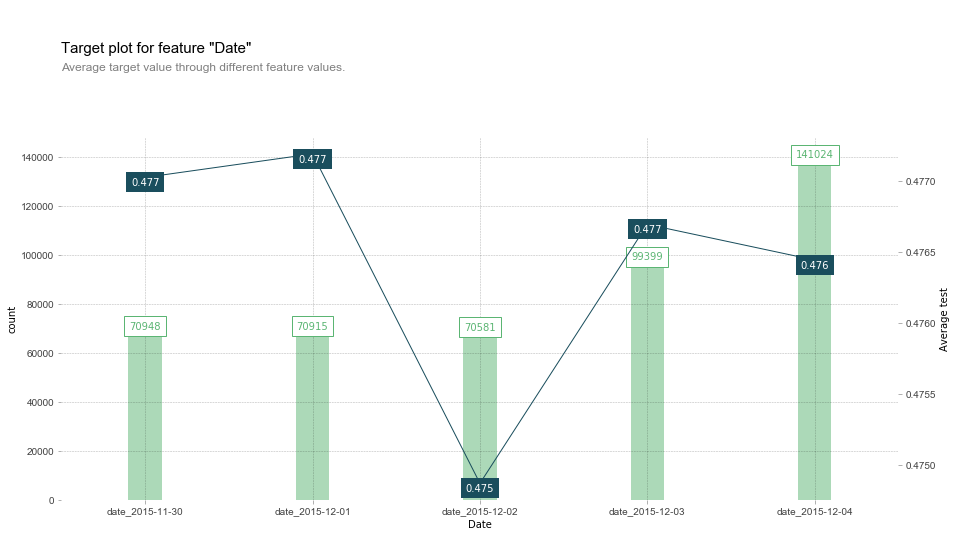

In [18]:
target_plot(df=data1, feature=['date_2015-11-30',
       'date_2015-12-01', 'date_2015-12-02', 'date_2015-12-03',
       'date_2015-12-04'],
    feature_name='Date', target='test')

(<Figure size 1080x648 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x10df591d0>,
  'bar_ax': <matplotlib.axes._subplots.AxesSubplot at 0x10df854a8>,
  'line_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a1ce84ac8>},
    x display_column   count      test
 0  0     source_Ads  181693  0.475792
 1  1  source_Direct   90738  0.474410
 2  2     source_SEO  180436  0.478170)

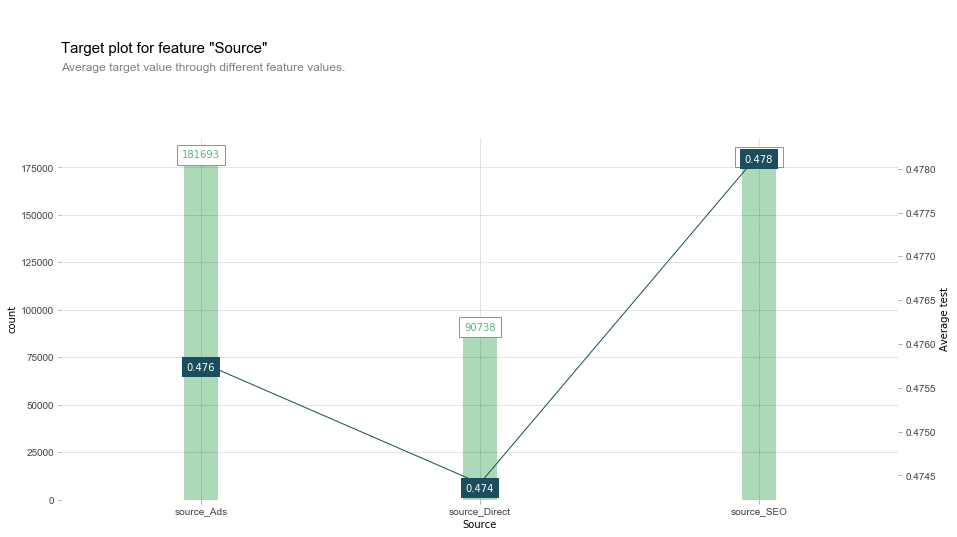

In [19]:
target_plot(df=data1, feature=['source_Ads', 'source_Direct', 'source_SEO'],
    feature_name='Source', target='test')

(<Figure size 1080x648 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a1c39e048>,
  'bar_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a1df439e8>,
  'line_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a1d8bb048>},
    x display_column   count      test
 0  0  device_Mobile  201551  0.477576
 1  1     device_Web  251316  0.475569)

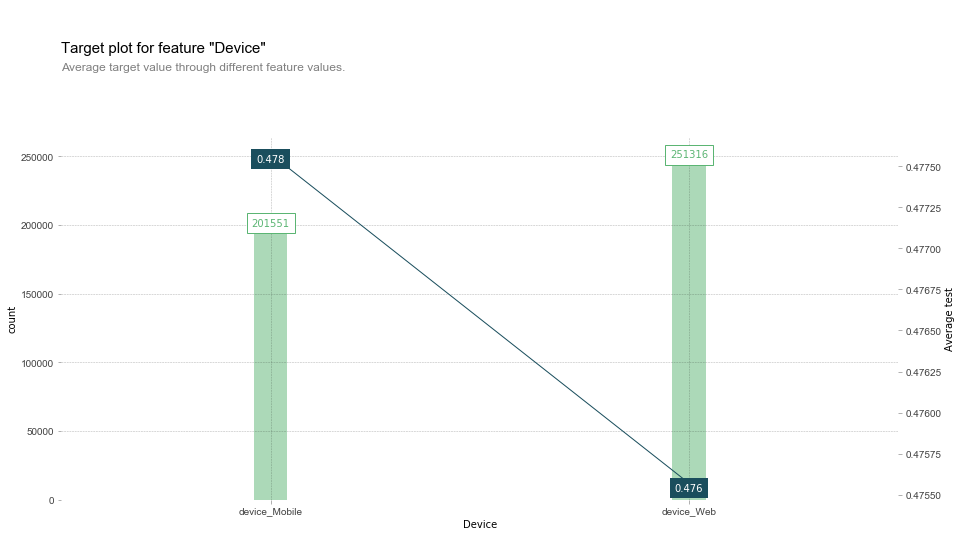

In [20]:
target_plot(df=data1, feature=['device_Mobile', 'device_Web'],
    feature_name='Device', target='test')

(<Figure size 1080x648 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a1d8431d0>,
  'bar_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a253539e8>,
  'line_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a20261048>},
    x        display_column  count      test
 0  0      ads_channel_Bing  13670  0.476079
 1  1  ads_channel_Facebook  68358  0.477003
 2  2    ads_channel_Google  68113  0.475357
 3  3     ads_channel_Other   4143  0.465846
 4  4     ads_channel_Yahoo  27409  0.475209)

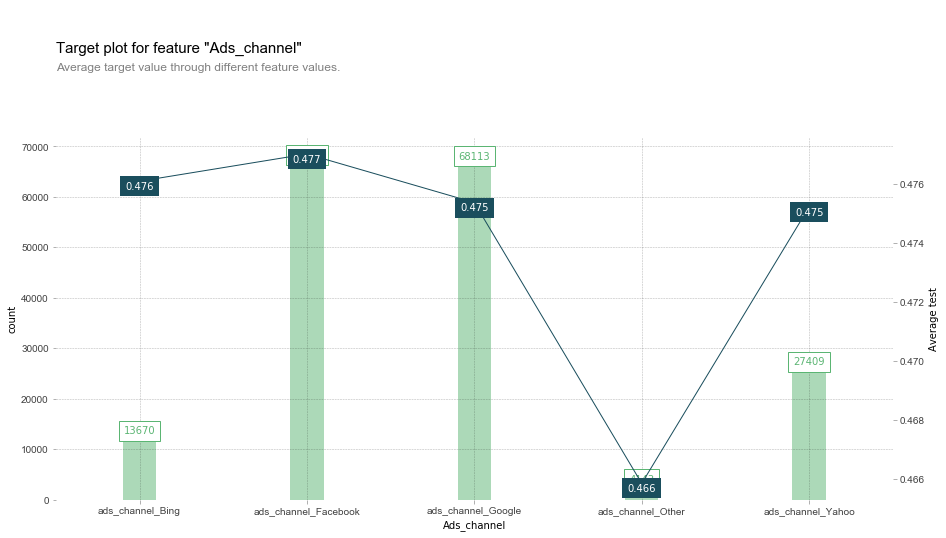

In [21]:
target_plot(df=data1, feature=['ads_channel_Bing',
       'ads_channel_Facebook', 'ads_channel_Google', 'ads_channel_Other',
       'ads_channel_Yahoo'],
    feature_name='Ads_channel', target='test')

(<Figure size 1080x648 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a2024a940>,
  'bar_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a201f82e8>,
  'line_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a1cd6e908>},
    x       display_column   count      test
 0  0  browser_Android_App  154977  0.478181
 1  1       browser_Chrome  101822  0.478826
 2  2      browser_FireFox   40721  0.475406
 3  3           browser_IE   61656  0.473887
 4  4   browser_Iphone_App   46574  0.475566
 5  5        browser_Opera    6084  0.473866
 6  6       browser_Safari   41033  0.470426)

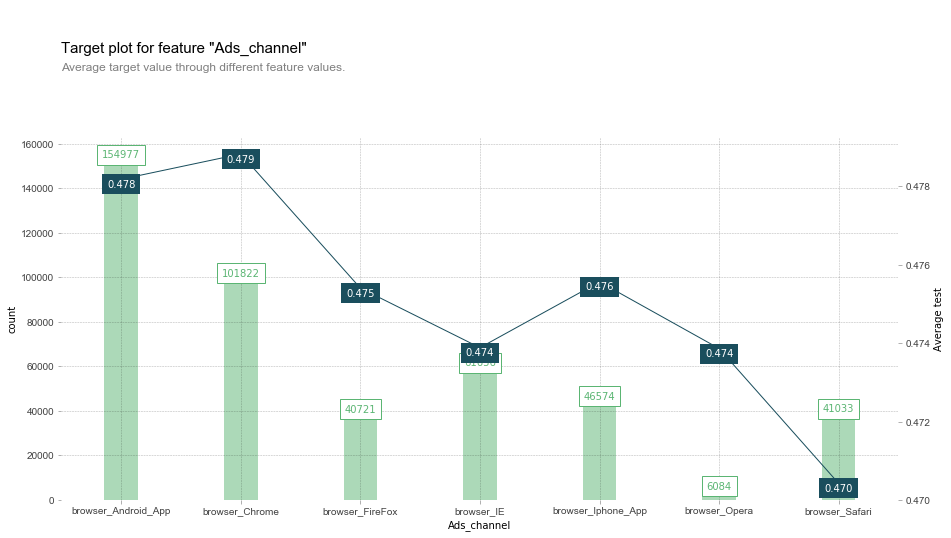

In [22]:
target_plot(df=data1, feature=['browser_Android_App', 'browser_Chrome',
       'browser_FireFox', 'browser_IE', 'browser_Iphone_App', 'browser_Opera',
       'browser_Safari'],
    feature_name='Ads_channel', target='test')

(<Figure size 1080x648 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a1cd22c50>,
  'bar_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a1d9bf278>,
  'line_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a1da83898>},
    x display_column   count      test
 0  0          sex_F  188382  0.477270
 1  1          sex_M  264485  0.475887)

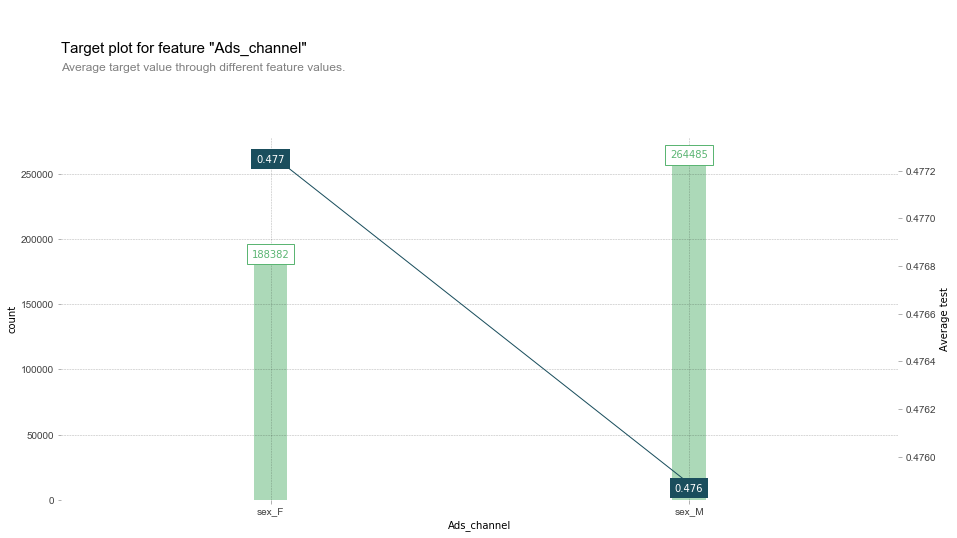

In [23]:
target_plot(df=data1, feature=['sex_F', 'sex_M'],
    feature_name='Ads_channel', target='test')

(<Figure size 1080x648 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a1da259b0>,
  'bar_ax': <matplotlib.axes._subplots.AxesSubplot at 0x10ed61da0>,
  'line_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a1f166400>},
      x       display_column   count      test
 0    0    country_Argentina   46733  0.799799
 1    1      country_Bolivia   11124  0.501079
 2    2        country_Chile   19737  0.500785
 3    3     country_Colombia   54060  0.498927
 4    4   country_Costa Rica    5309  0.498964
 5    5      country_Ecuador   15895  0.494432
 6    6  country_El Salvador    8175  0.497492
 7    7    country_Guatemala   15125  0.496066
 8    8     country_Honduras    8568  0.491013
 9    9       country_Mexico  128484  0.500257
 10  10    country_Nicaragua    6723  0.491447
 11  11       country_Panama    3951  0.502404
 12  12     country_Paraguay    7347  0.503199
 13  13         country_Peru   33666  0.498931
 14  14        country_Spain   51782  0.000000
 

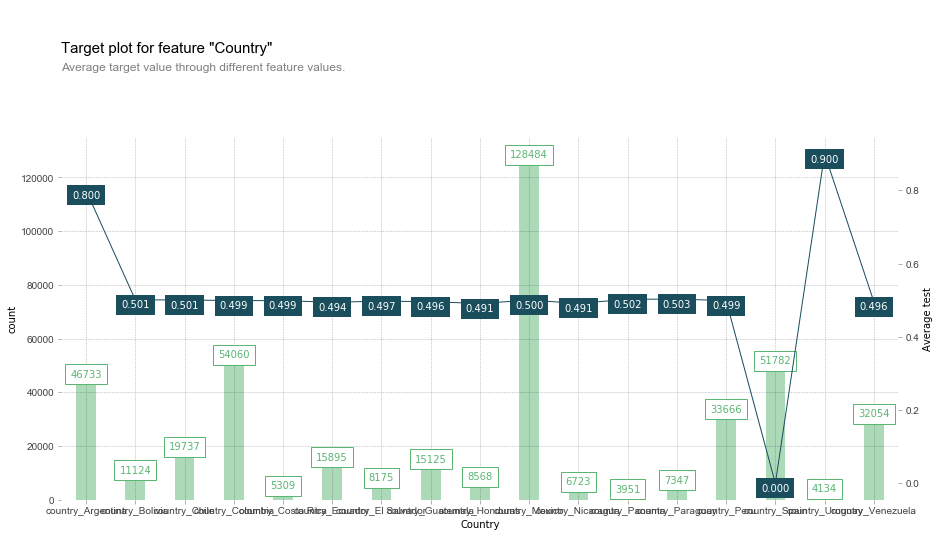

In [24]:
target_plot(df=data1, feature=['country_Argentina',
       'country_Bolivia', 'country_Chile', 'country_Colombia',
       'country_Costa Rica', 'country_Ecuador', 'country_El Salvador',
       'country_Guatemala', 'country_Honduras', 'country_Mexico',
       'country_Nicaragua', 'country_Panama', 'country_Paraguay',
       'country_Peru', 'country_Spain', 'country_Uruguay',
       'country_Venezuela'],
    feature_name='Country', target='test')

(<Figure size 1080x648 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a1db53550>,
  'bar_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a1db70978>,
  'line_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a1eed4f98>},
      x       display_column   count  conversion
 0    0    country_Argentina   46733    0.013994
 1    1      country_Bolivia   11124    0.048634
 2    2        country_Chile   19737    0.049704
 3    3     country_Colombia   54060    0.051332
 4    4   country_Costa Rica    5309    0.053494
 5    5      country_Ecuador   15895    0.049072
 6    6  country_El Salvador    8175    0.050765
 7    7    country_Guatemala   15125    0.049653
 8    8     country_Honduras    8568    0.049253
 9    9       country_Mexico  128484    0.050341
 10  10    country_Nicaragua    6723    0.053399
 11  11       country_Panama    3951    0.048089
 12  12     country_Paraguay    7347    0.048863
 13  13         country_Peru   33666    0.050258
 14  14        co

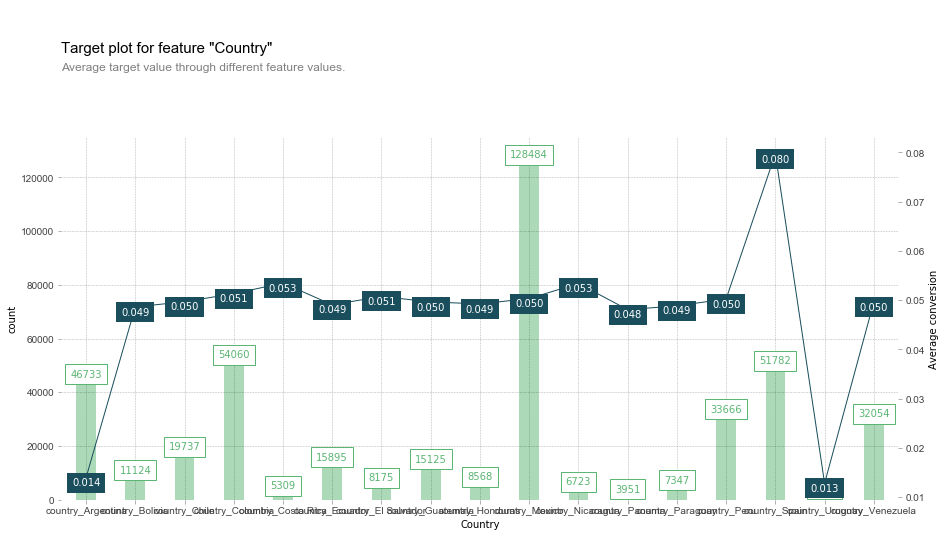

In [25]:
target_plot(df=data1, feature=['country_Argentina',
       'country_Bolivia', 'country_Chile', 'country_Colombia',
       'country_Costa Rica', 'country_Ecuador', 'country_El Salvador',
       'country_Guatemala', 'country_Honduras', 'country_Mexico',
       'country_Nicaragua', 'country_Panama', 'country_Paraguay',
       'country_Peru', 'country_Spain', 'country_Uruguay',
       'country_Venezuela'],
    feature_name='Country', target='conversion')

(<Figure size 1080x648 with 4 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a1f9fd0b8>,
  'bar_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a27861208>,
  'line_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a27886828>},
    x display_column  value_lower  value_upper percentile_column  \
 0  0       [18, 19)         18.0         19.0        [0, 11.11)   
 1  1       [19, 21)         19.0         21.0    [11.11, 22.22)   
 2  2       [21, 23)         21.0         23.0    [22.22, 33.33)   
 3  3       [23, 25)         23.0         25.0    [33.33, 44.44)   
 4  4       [25, 27)         25.0         27.0    [44.44, 55.56)   
 5  5       [27, 29)         27.0         29.0    [55.56, 66.67)   
 6  6       [29, 32)         29.0         32.0    [66.67, 77.78)   
 7  7       [32, 36)         32.0         36.0    [77.78, 88.89)   
 8  8       [36, 70]         36.0         70.0      [88.89, 100]   
 
    percentile_lower  percentile_upper  count      test  
 0          

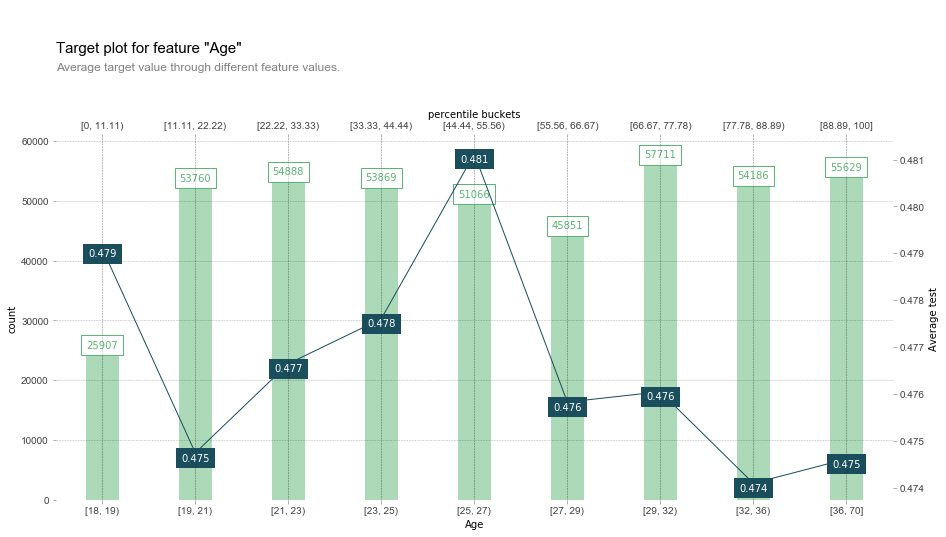

In [26]:
target_plot(
    df=data1, feature='age_age', feature_name='Age', target='test', show_percentile=True)

### Question 2: Explain why that might be happening.

As it is shown here that in most groups, the proportions of test cases are very close to the average proportion for the whole sample, except for the samples from Spain, Argentina, Uruguay. There are large difference between the proportion of test and that of control, which might results in some bias in the result. 

1.For the distribution of test and control from Argentina, the conversion rate is very low in Argentina. So, I believe that the imbalance in distribution between test and control from Argentina can drag the conversion rate to lower level even when the change doesn't have significant effect on the conversion. It might tend to lead to the conclusion of the conclusion that the conversion rate drops after change. 

2.For the distribution of test and control from Uruguay, there are only a small very number of observations from Uruguay. It might tend to lead very slightly to the conclusion of the conclusion that the conversion rate increase after change. 

3.What's more, all the cases from Spain are considered as control case and there is a large number of observations from Spain. However, the conversion rate is uncommonly high in Spain. This will result in bias in the difference between test and control if the conversion rate in Spain is taken into account in control group but it is not included in the test group. It might tend to lead to the conclusion of the conclusion that the conversion rate drops after change. 

In [27]:
data['age'][data['age']>65]=65

In [28]:
def calc_diff(vars,data):
    conversion_0 = []
    conversion_1 = []
    pop_0 = []
    pop_1 = []
    diffs_1_0 = []
    index_s1 = []

    for v in vars:
        converted = pd.DataFrame(data.groupby([v,'test'])['conversion'].sum()).reset_index()
        all_pop = pd.DataFrame(data.groupby([v,'test'])['conversion'].count()).reset_index()

        if v == 'country'and any(data['country']=='Spain'):
            add0 = {'country':['Spain'],'test':[1],'conversion':[0]}
            add0 = pd.DataFrame(add0)
            add1 = {'country':['Spain'],'test':[1],'conversion':[1]}
            add1 = pd.DataFrame(add1)
            converted = pd.concat([converted,add0]).sort_values('country')
            all_pop = pd.concat([all_pop,add1]).sort_values('country')  

        converted['ratio'] = converted['conversion']/all_pop['conversion']
        conversion_0 = conversion_0 + converted[converted['test']==0]['ratio'].tolist()
        conversion_1 = conversion_1 + converted[converted['test']==1]['ratio'].tolist()
        pop_0 = pop_0 + all_pop[all_pop['test']==0]['conversion'].tolist()
        pop_1 = pop_1 + all_pop[all_pop['test']==1]['conversion'].tolist()
        index_s1 = index_s1 + converted[converted['test']==1][v].tolist()
        #print(v,"---",len(conversion_0),"---",len(conversion_1))
    diffs_1_0=list(np.round(np.array(conversion_1)-np.array(conversion_0),4))
    diff = pd.DataFrame(index = index_s1,data=diffs_1_0,columns=['difference'])
    diff['control_size'] = pop_0
    diff['test_size'] = pop_1
    return diff

In [29]:
diff = calc_diff(vars,data)

In [30]:
data_nSAU = data[~data['country'].isin(['Spain','Argentina','Uruguay'])]

In [31]:
diff_nSAU = calc_diff(vars,data_nSAU)

In [32]:
print('The conversion rate grows in ',diff_nSAU[diff_nSAU['difference']>0].shape[0],' sections, in ',
     sum(diff_nSAU[diff_nSAU['difference']>0]['test_size']),'test cases and ', sum(diff_nSAU[diff_nSAU['difference']>0]['control_size']),
     'control cases.')
print('The conversion rate stays the same in ',diff_nSAU[diff_nSAU['difference']==0].shape[0],' sections, in ',
     sum(diff_nSAU[diff_nSAU['difference']==0]['test_size']),'test cases and ', sum(diff_nSAU[diff_nSAU['difference']==0]['control_size']),
     'control cases.')
print('The conversion rate drops in ',diff_nSAU[diff_nSAU['difference']<0].shape[0],' sections, in ',
     sum(diff_nSAU[diff_nSAU['difference']<0]['test_size']),'test cases and ', sum(diff_nSAU[diff_nSAU['difference']<0]['control_size']),
     'control cases.')

The conversion rate grows in  43  sections, in  781347 test cases and  783742 control cases.
The conversion rate stays the same in  8  sections, in  42 test cases and  71 control cases.
The conversion rate drops in  34  sections, in  511318 test cases and  515395 control cases.


In [33]:
print('The conversion rate grows in ',diff[diff['difference']>0].shape[0],' sections, in ',
     sum(diff[diff['difference']>0]['test_size']),'test cases and ', sum(diff[diff['difference']>0]['control_size']),
     'control cases.')
print('The conversion rate stays the same in ',diff[diff['difference']==0].shape[0],' sections, in ',
     sum(diff[diff['difference']==0]['test_size']),'test cases and ', sum(diff[diff['difference']==0]['control_size']),
     'control cases.')
print('The conversion rate drops in ',diff[diff['difference']<0].shape[0],' sections, in ',
     sum(diff[diff['difference']<0]['test_size']),'test cases and ', sum(diff[diff['difference']<0]['control_size']),
     'control cases.')

The conversion rate grows in  15  sections, in  108021 test cases and  104971 control cases.
The conversion rate stays the same in  8  sections, in  48 test cases and  87 control cases.
The conversion rate drops in  66  sections, in  1488798 test cases and  1649838 control cases.


### Question1: Confirm that the test is actually negative

There is no substantial evidence that the test is actually negative. Because it is shown that after the biased segments are removed, there are more sections or a larger population with an improved conversion rate.


### Quetion2: Are the localized translations really worse?

#### Statistical Test

In [34]:
data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,1,2015-12-02,SEO,Web,EN,NaN,Chrome,0,0,M,38,Chile
1,2,2015-11-30,SEO,Mobile,ES,NaN,Android_App,0,0,M,27,Colombia
2,3,2015-12-03,SEO,Mobile,ES,NaN,Iphone_App,0,1,M,18,Guatemala
3,5,2015-11-30,Ads,Web,ES,Facebook,Chrome,0,1,M,22,Argentina
4,8,2015-12-03,Ads,Mobile,ES,Google,Android_App,0,1,M,19,Venezuela


In [35]:
data2 = data[data['browser_language']=='ES']
data2_nSAU = data2[~data2['country'].isin(['Spain','Argentina','Uruguay'])]

In [36]:
def standerror(data):
    SE = np.std(data)/(data.shape[0]**(1/2))
    return SE

In [42]:
def checkchange(df,msamples,seed):
    random.seed(seed)
    df_ctrl = df[df['test']==0]
    r_ctrl = sum(df_ctrl['conversion'])/df_ctrl.shape[0]
    df_test = df[df['test']==1]
    r_test = sum(df_test['conversion'])/df_test.shape[0]
    df_ctrl['randNumCol'] = np.random.randint(1, msamples, df_ctrl.shape[0])
    df_test['randNumCol'] = np.random.randint(1, msamples, df_test.shape[0])
    df = pd.concat([df_test,df_ctrl],axis=0)
    stds = pd.DataFrame(df.groupby('randNumCol')['conversion'].apply(standerror))
    SE_emp = stds['conversion'].mean()
    SE = SE_emp*((1/df_ctrl.shape[0]+1/df_test.shape[0])**(1/2))*(msamples/df_ctrl.shape[0]+msamples/df_test.shape[0])**(-1/2)
    CI = st.norm.interval(0.95, loc=0, scale=SE)
    rate_diff = r_test - r_ctrl
    return [CI,rate_diff,SE]

In [43]:
[CI_all,rate_diff_all,SE] = checkchange(data2_nSAU,50,1)

In [39]:
CI_all[0]<rate_diff_all

True

In [40]:
rate_diff_all<CI_all[1]

True

In [44]:
st.norm.cdf(rate_diff_all, scale=SE)

0.5479449739825307

##### Segmentation Analysis (countries)

In [46]:
data_argentina = data[data['country']=='Argentina']
data_uruguay = data[data['country']=='Uruguay']
print(sum(data_argentina['test'])/data_argentina.shape[0])
print(sum(data_uruguay['test'])/data_uruguay.shape[0])

0.7997988573384974
0.8996129656507015


In [47]:
countrylist = data['country'].unique().tolist()
countrylist.remove('Spain')

In [71]:
CIs = []
rate_diffs = []
SEs = []
Ps = []
for country in countrylist:
    df_country = data2[data2['country']==country]
    n_sample = round(df_country.shape[0]/2000)
    [CI,rate_diff,SE] = checkchange(df_country,n_sample,1)
    CIs.append(CI)
    SEs.append(SE)
    rate_diffs.append(rate_diff)
    if rate_diff>CI[1] or rate_diff<CI[0]:
        print("There is significant change in", country)
    p = st.norm.cdf(rate_diff, scale=SE)
    Ps.append(p)
seg_table_country = pd.DataFrame(list(zip(countrylist,CIs,rate_diffs,SEs,Ps)),columns = ['country','confidence interval','rate difference','standard error','cdf'])

There is significant change in Argentina
There is significant change in El Salvador
There is significant change in Uruguay


In [73]:
seg_table_country.sort_values(by = ['cdf'])

,country,confidence interval,rate difference,standard error,cdf
13,El Salvador,"(-0.00430807044108852, 0.00430807044108852)",-0.005796,0.002198,0.004183
3,Argentina,"(-0.0011400054798055552, 0.0011400054798055552)",-0.001330,0.000582,0.011123
1,Colombia,"(-0.002005682417247813, 0.002005682417247813)",-0.001873,0.001023,0.033609
9,Ecuador,"(-0.0034179949400293696, 0.0034179949400293696)",-0.001597,0.001744,0.179853
11,Honduras,"(-0.004363160835254522, 0.004363160835254522)",-0.001610,0.002226,0.234710
4,Venezuela,"(-0.002511166040542841, 0.002511166040542841)",-0.000882,0.001281,0.245694
5,Paraguay,"(-0.004346055248111709, 0.004346055248111709)",-0.000176,0.002217,0.468409
8,Bolivia,"(-0.003949521823025596, 0.003949521823025596)",-0.000145,0.002015,0.471246
12,Nicaragua,"(-0.004826015029501866, 0.004826015029501866)",0.000546,0.002462,0.587735
14,Costa Rica,"(-0.0046634670859524285, 0.0046634670859524285)",0.001705,0.002379,0.763188


In [76]:
seg_table_country[seg_table_country['country'].isin(['Argentina','El Salvador','Uruguay'])]

,country,confidence interval,rate difference,standard error,cdf
3,Argentina,"(-0.0011400054798055552, 0.0011400054798055552)",-0.001330,0.000582,0.011123
13,El Salvador,"(-0.00430807044108852, 0.00430807044108852)",-0.005796,0.002198,0.004183
15,Uruguay,"(-0.002427576612326209, 0.002427576612326209)",0.002548,0.001239,0.980160


##### Conclusion

Since the difference of conversion rate between test and control group is still within the 95% confidence interval and the difference is very close to zero, the effect of change is not significant for the whole population.

As for the result of segmentation analysis, it seems like for most countries, there is no signficant change in conversion rate, except for El Salvador, Argentina and Uruguay. 

In Argentina, the conversion rate drops after the change.

In El Salvador, the conversion rate drops significantly after the change.

In Uruguay, the conversion rate grows after the change.

##### Segmentation Analysis (date)

In [51]:
datelist = data['date'].unique().tolist()

In [74]:
CIs_date = []
rate_diffs_date = []
SEs_date = []
Ps_date = []
for date in datelist:
    df_date = data2_nSAU[data2_nSAU['date']==date]
    n_sample = round(df_date.shape[0]/2000)
    [CI,rate_diff,SE] = checkchange(df_date,n_sample,1)
    CIs_date.append(CI)
    SEs_date.append(SE)
    rate_diffs_date.append(rate_diff)
    if rate_diff>CI[1] or rate_diff<CI[0]:
        print("There is significant change in", date)
    p = st.norm.cdf(rate_diff, scale=SE)
    Ps_date.append(p)
seg_table_date = pd.DataFrame(list(zip(datelist,CIs_date,rate_diffs_date,SEs_date,Ps_date)),columns = ['date','confidence interval','rate difference','standard error','cdf'])

There is significant change in 2015-12-04


In [75]:
seg_table_date.sort_values(by=['cdf'])

,date,confidence interval,rate difference,standard error,cdf
4,2015-12-01,"(-0.0019224439884392664, 0.0019224439884392664)",-0.001595,0.000981,0.051945
2,2015-12-03,"(-0.0016695988073657502, 0.0016695988073657502)",-0.001062,0.000852,0.106229
1,2015-11-30,"(-0.0020046581056124904, 0.0020046581056124904)",-0.000638,0.001023,0.266405
0,2015-12-02,"(-0.0019724368477045603, 0.0019724368477045603)",0.000458,0.001006,0.675316
3,2015-12-04,"(-0.0014033577120621521, 0.0014033577120621521)",0.001815,0.000716,0.994369


##### Conclusion:

For most days, the differences are not significant, except for 2015-12-04.

On 2015-12-04, the conversion rate grows significantly.

#### Sign Test

In [77]:
data2.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
1,2,2015-11-30,SEO,Mobile,ES,NaN,Android_App,0,0,M,27,Colombia
2,3,2015-12-03,SEO,Mobile,ES,NaN,Iphone_App,0,1,M,18,Guatemala
3,5,2015-11-30,Ads,Web,ES,Facebook,Chrome,0,1,M,22,Argentina
4,8,2015-12-03,Ads,Mobile,ES,Google,Android_App,0,1,M,19,Venezuela
5,11,2015-12-03,Ads,Web,ES,Yahoo,Chrome,0,1,F,28,Colombia


In [78]:
data2_date = pd.DataFrame(data2_nSAU.groupby(['date','test'])['conversion'].sum()/data2_nSAU.groupby(['date','test'])['conversion'].count()).reset_index()

In [79]:
data2_date_test = data2_date[data2_date['test']==1]
data2_date_ctrl = data2_date[data2_date['test']==0]

In [80]:
data2_date_test['sign'] = np.array(data2_date_test['conversion']) - np.array(data2_date_ctrl['conversion'])

In [81]:
data2_date_ctrl

,date,test,conversion
0,2015-11-30,0,0.053191
2,2015-12-01,0,0.049354
4,2015-12-02,0,0.050527
6,2015-12-03,0,0.051198
8,2015-12-04,0,0.049177


In [82]:
data2_date_test

,date,test,conversion,sign
1,2015-11-30,1,0.052553,-0.000638
3,2015-12-01,1,0.047758,-0.001595
5,2015-12-02,1,0.050984,0.000458
7,2015-12-03,1,0.050136,-0.001062
9,2015-12-04,1,0.050992,0.001815


In [83]:
from scipy.stats import binom
binom.cdf(2, 5, 0.5, loc=0)

0.5

##### Conclusion:
Because I only have data for 5 days, the data for sign test is too sparse to draw a solid conclusion. But it seems like, in 3 days out of 5 days, the test group has less conversion rate. But, according to the binomial distribution with the probability of success being 0.5, there are 50% of chances that 2 successes occur among 5 trials.

So, according to the sign test, there is no significant evidence that this change has any effect on the conversion rate in the target area.

### Answer:

Overall, the localized translation does change the conversion rate.

But for some certain area and date, it significantly changes the conversion rate:

    On 2015-12-04, the conversion rate grows significantly.

    In Argentina, the conversion rate drops after the change.

    In El Salvador, the conversion rate drops significantly after the change.

    In Uruguay, the conversion rate grows after the change.
    
After answering question 3, the next step can be look into the distributions of specific variables in these segmentations.

### Question3: If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.

In [92]:
p = data['test'].sum()/data['test'].count()
se = (p*(1-p)/data['test'].count())**(1/2)
ci =st.norm.interval(0.95,loc = p,scale=se)

In [104]:
data['test'].mean()

0.4764621842616044

In [105]:
def ci_lower(data):
    MEAN = data.mean()
    SE = np.std(data)/(data.shape[0]**(1/2))
    CI_LOWER = MEAN - 1.96*SE
    return CI_LOWER

def ci_upper(data):
    MEAN = data.mean()
    SE = np.std(data)/(data.shape[0]**(1/2))
    CI_UPPER = MEAN + 1.96*SE
    return CI_UPPER

In [107]:
cis_test_lower = pd.DataFrame()
cis_test_upper = pd.DataFrame()
for v in ['date', 'source', 'device', 'browser_language',
       'ads_channel', 'browser', 'sex', 'age','country']:
    ci_test_lower = pd.DataFrame(data.groupby(v)['test'].apply(ci_lower))
    ci_test_upper = pd.DataFrame(data.groupby(v)['test'].apply(ci_upper))
    cis_test_lower = pd.concat([cis_test_lower,ci_test_lower])
    cis_test_upper = pd.concat([cis_test_upper,ci_test_upper])

In [111]:
cis_test = pd.concat([cis_test_lower,cis_test_upper],axis = 1)
cis_test.columns = ['ci_lower','ci_upper']

In [112]:
cis_test[(cis_test['ci_lower']>ci[1])|(cis_test['ci_upper']<ci[0])]

,ci_lower,ci_upper
57,0.203954,0.462713
58,0.108421,0.424912
Argentina,0.796171,0.803427
Bolivia,0.491787,0.510370
Chile,0.493810,0.507761
Colombia,0.494712,0.503142
Costa Rica,0.485514,0.512414
Ecuador,0.486660,0.502205
El Salvador,0.486654,0.508331
Guatemala,0.488098,0.504034


In [128]:
def sanity_check(test,varlist,data):
    p = data[test].sum()/data[test].count()
    se = (p*(1-p)/data[test].count())**(1/2)
    ci =st.norm.interval(0.95,loc = p,scale=se)
    cis_test_lower = pd.DataFrame()
    cis_test_upper = pd.DataFrame()
    for v in varlist:
        ci_test_lower = pd.DataFrame(data.groupby(v)[test].apply(ci_lower))
        ci_test_upper = pd.DataFrame(data.groupby(v)[test].apply(ci_upper))
        cis_test_lower = pd.concat([cis_test_lower,ci_test_lower])
        cis_test_upper = pd.concat([cis_test_upper,ci_test_upper])
    cis_test = pd.concat([cis_test_lower,cis_test_upper],axis = 1)
    cis_test.columns = ['ci_lower','ci_upper']
    result = cis_test[(cis_test['ci_lower']>ci[1])|(cis_test['ci_upper']<ci[0])]
    return (result.shape[0]==0)

In [129]:
sanity_check('test',['date', 'source', 'device', 'browser_language',
       'ads_channel', 'browser', 'sex', 'age','country'],data)

False

In [125]:
data_nSAU['age'][data_nSAU['age']>56]=56

In [130]:
sanity_check('test',['date', 'source', 'device', 'browser_language',
       'ads_channel', 'browser', 'sex', 'age','country'],data_nSAU)

True